In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import xgboost as xgb
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [11]:
train = pd.read_csv('archive/coin_Bitcoin.csv')
print(train.shape)
train.head()

(2991, 10)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [13]:
print(train.info())
train.describe()
print(len(train))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB
None
2991


In [14]:
train.index = pd.to_datetime(train['Date'])
train.index

DatetimeIndex(['2013-04-29 23:59:59', '2013-04-30 23:59:59',
               '2013-05-01 23:59:59', '2013-05-02 23:59:59',
               '2013-05-03 23:59:59', '2013-05-04 23:59:59',
               '2013-05-05 23:59:59', '2013-05-06 23:59:59',
               '2013-05-07 23:59:59', '2013-05-08 23:59:59',
               ...
               '2021-06-27 23:59:59', '2021-06-28 23:59:59',
               '2021-06-29 23:59:59', '2021-06-30 23:59:59',
               '2021-07-01 23:59:59', '2021-07-02 23:59:59',
               '2021-07-03 23:59:59', '2021-07-04 23:59:59',
               '2021-07-05 23:59:59', '2021-07-06 23:59:59'],
              dtype='datetime64[ns]', name='Date', length=2991, freq=None)

In [15]:
def create_features(df):
    df['dayofweek'] = df.index.day_of_week
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    return df
train = create_features(train)
train.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,dayofweek,month,dayofyear
Date,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,0,4,119
2013-04-30 23:59:59,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,1,4,120
2013-05-01 23:59:59,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,2,5,121
2013-05-02 23:59:59,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,3,5,122
2013-05-03 23:59:59,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,4,5,123


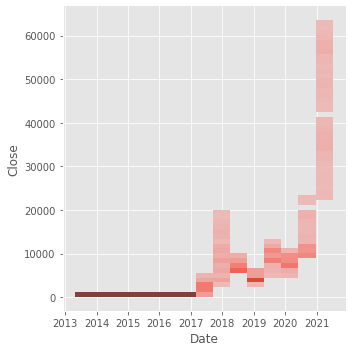

In [16]:
sns.displot(data=train,x=train.index ,y='Close')


In [18]:
split_row = len(train) - int(0.2 * len(train))
train_data = train.iloc[:split_row]
test_data = train.iloc[split_row:]

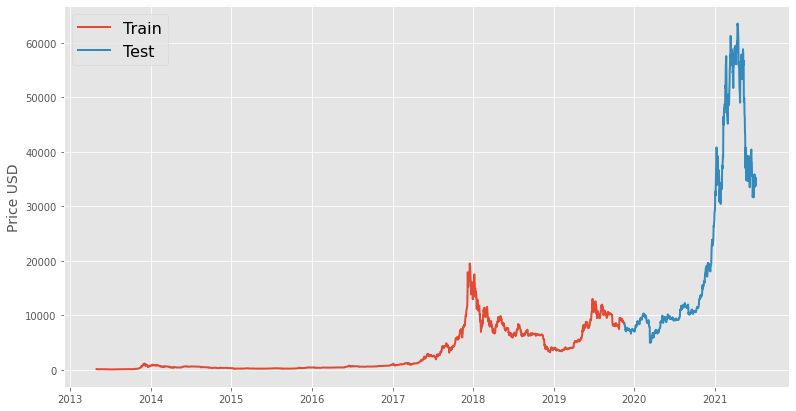

In [20]:
chosen_col = 'Close'
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [22]:
from sklearn.preprocessing import MinMaxScaler

datacol = train.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

In [24]:
train_scaled_data

array([[0.00119979],
       [0.00111246],
       [0.00076549],
       ...,
       [0.13619706],
       [0.13279037],
       [0.13371681]])

In [25]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

In [30]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
59/59 [==============================] - 4s 29ms/step - loss: 5.2569e-04 - val_loss: 6.2278e-05
Epoch 2/100
59/59 [==============================] - 1s 20ms/step - loss: 8.6765e-05 - val_loss: 5.4519e-05
Epoch 3/100
59/59 [==============================] - 1s 19ms/step - loss: 8.8350e-05 - val_loss: 5.1027e-05
Epoch 4/100
59/59 [==============================] - 1s 20ms/step - loss: 8.2381e-05 - val_loss: 9.6753e-05
Epoch 5/100
59/59 [==============================] - 1s 20ms/step - loss: 7.7620e-05 - val_loss: 4.7691e-05
Epoch 6/100
59/59 [==============================] - 1s 20ms/step - loss: 6.9730e-05 - val_loss: 5.2268e-05
Epoch 7/100
59/59 [==============================] - 1s 20ms/step - loss: 7.5080e-05 - val_loss: 4.4033e-05
Epoch 8/100
59/59 [==============================] - 1s 20ms/step - loss: 6.4138e-05 - val_loss: 4.9286e-05
Epoch 9/100
59/59 [==============================] - 1s 21ms/step - loss: 5.8730e-05 - val_loss: 4.7792e-05
Epoch 10/100
59/59 [========

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

18/18 [==============================] - 1s 6ms/step


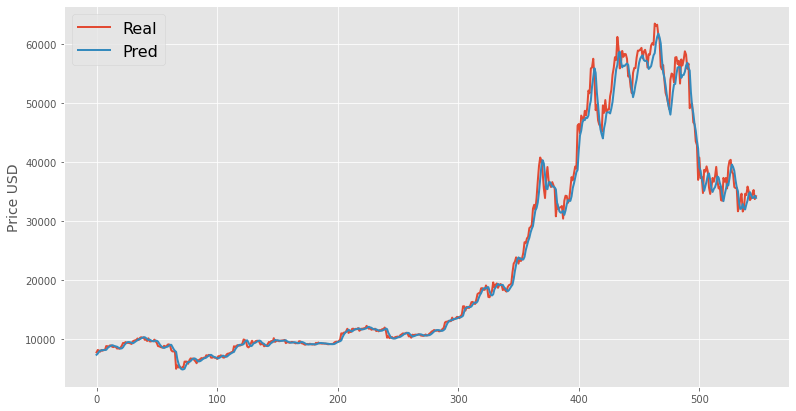

In [33]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [39]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_price, inv_price)


888.9706536792816